In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip install -q gymnasium

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]

### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [ ]:
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import gymnasium as gym

env = gym.make("Acrobot-v1", render_mode="rgb_array")
env.reset()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Action Space Discrete(3)


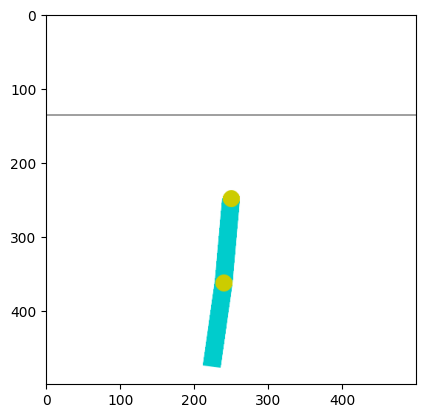

In [ ]:
plt.imshow(env.render())

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method.

This essentially means we're actually training a stochastic policy $\pi_\theta \left( a \middle| s \right)$.

And yes, it's gonna be a neural network. So let's start by defining one.

In [ ]:
class TRPOAgent(nn.Module):
    def __init__(self, state_shape: Tuple[int], n_actions: int):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple:
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        super().__init__()

        assert isinstance(state_shape, tuple)
        assert len(state_shape) == 1
        input_dim = state_shape[0]

        # Prepare your model here.
        self.layer1 = nn.Linear(input_dim, 500)
        self.layer2 = nn.Linear(500, 128)
        self.layer3 = nn.Linear(128, n_actions)

        self.model = nn.Sequential(
            self.layer1,
            nn.ReLU(),
            self.layer2,
            nn.ReLU(),
            self.layer3
        )

    def forward(self, states: torch.Tensor):
        """
        takes agent's observation, returns log-probabilities
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """

        # Use your network to compute log_probs for the given states.
        out = self.model(states)
        log_probs = F.log_softmax(out, dim=-1)

        return log_probs

    def get_log_probs(self, states: torch.Tensor):
        '''
        Log-probs for training
        '''
        return self.forward(states)

    def get_probs(self, states: torch.Tensor):
        '''
        Probs for interaction
        '''
        return torch.exp(self.forward(states))

    def act(self, obs: np.ndarray, sample: bool = True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        with torch.no_grad():
            probs = self.get_probs(torch.tensor(obs[np.newaxis], dtype=torch.float32)).numpy()

        if sample:
            action = int(np.random.choice(n_actions, p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]


agent = TRPOAgent(observation_shape, n_actions)

In [ ]:
# Check if log-probabilities satisfies all the requirements
log_probs = agent.get_log_probs(torch.tensor(env.reset()[0][np.newaxis], dtype=torch.float32))
assert (
    isinstance(log_probs, torch.Tensor) and
    log_probs.requires_grad
), "log_probs must be a torch.Tensor with grad"
assert log_probs.shape == (1, n_actions)
sums = torch.exp(log_probs).sum(dim=1)
assert torch.allclose(sums, torch.ones_like(sums))

# Demo use
print("sampled:", [agent.act(env.reset()[0]) for _ in range(5)])
print("greedy:", [agent.act(env.reset()[0], sample=False) for _ in range(5)])

sampled: [(0, array([0.36914775, 0.31602034, 0.3148319 ], dtype=float32)), (0, array([0.36691156, 0.317614  , 0.31547448], dtype=float32)), (1, array([0.36900473, 0.31697115, 0.31402412], dtype=float32)), (2, array([0.36654046, 0.31782782, 0.31563178], dtype=float32)), (0, array([0.36924538, 0.31622297, 0.31453165], dtype=float32))]
greedy: [(0, array([0.3689319 , 0.31581053, 0.31525764], dtype=float32)), (0, array([0.368281 , 0.3169169, 0.3148021], dtype=float32)), (0, array([0.37044257, 0.31579795, 0.31375945], dtype=float32)), (0, array([0.3725225 , 0.31393698, 0.31354055], dtype=float32)), (0, array([0.36724284, 0.31605095, 0.31670624], dtype=float32))]


#### Flat parameters operations

We are going to use it

In [ ]:
def get_flat_params_from(model):
    params = [torch.ravel(param.detach()) for param in model.parameters()]
    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.shape)))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].reshape(param.shape)
        )
        prev_ind += flat_size

Compute cumulative reward just like you did in vanilla REINFORCE

In [ ]:
import scipy.signal


def get_cumulative_returns(r, gamma=1):
    """
    Computes cumulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

In [ ]:
# simple demo on rewards [0,0,1,0,0,1]
get_cumulative_returns([0, 0, 1, 0, 0, 1], gamma=0.9)

array([1.40049, 1.5561 , 1.729  , 0.81   , 0.9    , 1.     ])

**Rollout**

In [ ]:
def rollout(env, agent, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0
    while total_timesteps < n_timesteps:
        obervations, actions, rewards, action_probs = [], [], [], []
        obervation, _ = env.reset()
        for _ in range(max_pathlength):
            action, policy = agent.act(obervation)
            obervations.append(obervation)
            actions.append(action)
            action_probs.append(policy)
            obervation, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1
            if terminated or truncated or total_timesteps >= n_timesteps:
                path = {
                    "observations": np.array(obervations),
                    "policy": np.array(action_probs),
                    "actions": np.array(actions),
                    "rewards": np.array(rewards),
                    "cumulative_returns": get_cumulative_returns(rewards),
                }
                paths.append(path)
                break
    return paths

In [ ]:
from pprint import pprint

paths = rollout(env, agent, max_pathlength=5, n_timesteps=100)
pprint(paths[-1])

assert (paths[0]['policy'].shape == (5, n_actions))
assert (paths[0]['cumulative_returns'].shape == (5,))
assert (paths[0]['rewards'].shape == (5,))
assert (paths[0]['observations'].shape == (5,) + observation_shape)
assert (paths[0]['actions'].shape == (5,))

print("It's ok")

{'actions': array([2, 0, 1, 1, 2]),
 'cumulative_returns': array([-5., -4., -3., -2., -1.]),
 'observations': array([[ 9.9997956e-01, -6.3958843e-03,  9.9874842e-01,  5.0016087e-02,
         3.9117727e-02,  1.0686488e-02],
       [ 9.9994552e-01, -1.0438226e-02,  9.9673164e-01,  8.0784261e-02,
        -7.7552170e-02,  2.9132867e-01],
       [ 9.9995995e-01, -8.9487052e-03,  9.9566919e-01,  9.2967160e-02,
         9.2216507e-02, -1.7032471e-01],
       [ 9.9993604e-01,  1.1309773e-02,  9.9872971e-01,  5.0387941e-02,
         1.0493503e-01, -2.4610253e-01],
       [ 9.9952966e-01,  3.0666269e-02,  9.9999982e-01, -5.7601504e-04,
         8.3192207e-02, -2.5200924e-01]], dtype=float32),
 'policy': array([[0.36945704, 0.3153622 , 0.31518075],
       [0.36919028, 0.31485322, 0.31595653],
       [0.36867663, 0.31638652, 0.31493685],
       [0.36825538, 0.31698284, 0.31476176],
       [0.36742938, 0.3176967 , 0.314874  ]], dtype=float32),
 'rewards': array([-1., -1., -1., -1., -1.])}
It's ok


### Step 3: Auxiliary functions

Now let's define the loss functions and something else for actual TRPO training.

The surrogate reward should be:
$$J_{surr}= {1 \over N} \sum\limits_{i=1}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

For simplicity, in this assignment we are going to use cumulative rewards instead of advantage:
$$J'_{surr}= {1 \over N} \sum\limits_{i=1}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

Since we want to maximize the reward, we are going to minimize the corresponding surrogate loss:
$$ L_{surr} = - J'_{surr} $$


In [ ]:
def get_loss(agent, observations, actions, cumulative_returns, old_probs):
    """
    Computes TRPO objective
    :param: observations - batch of observations [timesteps x state_shape]
    :param: actions - batch of actions [timesteps]
    :param: cumulative_returns - batch of cumulative returns [timesteps]
    :param: old_probs - batch of probabilities computed by old network [timesteps x num_actions]
    :returns: scalar value of the objective function
    """
    batch_size = observations.shape[0]
    probs_all = agent.get_probs(observations)

    probs_for_actions = probs_all[torch.arange(batch_size), actions]     # Probabilities for played actions for new policy
    old_probs_for_actions = old_probs[torch.arange(batch_size), actions] # Probabilities for played actions for old policy

    # Compute surrogate loss, aka importance-sampled policy gradient
    loss = -torch.mean((probs_for_actions/old_probs_for_actions) * cumulative_returns)

    assert loss.ndim == 0
    return loss

We can ascend these gradients as long as our $\pi_\theta(a|s)$ satisfies the constraint
$$\mathbb{E}_{s,\pi_{\theta_{t}}} \Big[ \operatorname{KL} \left( \pi_{\theta_{t}} (s) \:\|\: \pi_{\theta_{t+1}} (s) \right) \Big] < \alpha$$


where

$$\operatorname{KL} \left( p \| q \right) = \mathbb{E}_p \log \left( \frac p q \right)$$

In [ ]:
def get_kl(agent, observations, actions, cumulative_returns, old_probs):
    """
    Computes KL-divergence between network policy and old policy
    :param: observations - batch of observations [timesteps x state_shape]
    :param: actions - batch of actions [timesteps]
    :param: cumulative_returns - batch of cumulative returns [timesteps] (we don't need it actually)
    :param: old_probs - batch of probabilities computed by old network [timesteps x num_actions]
    :returns: scalar value of the KL-divergence
    """
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    # Compute Kullback-Leibler divergence (see formula above).
    # Note: you need to sum KL and entropy over all actions, not just the ones agent took.
    # You will also need to compute max KL over all timesteps.
    old_log_probs_all = torch.log(old_probs + 1e-10)

    kl = torch.sum(old_probs * (old_log_probs_all - log_probs_all)) / batch_size

    assert kl.ndim == 0
    assert (kl > -0.0001).all() and (kl < 10000).all()
    return kl

In [ ]:
def get_entropy(agent, observations):
    """
    Computes entropy of the network policy
    :param: observations - batch of observations
    :returns: scalar value of the entropy
    """

    observations = torch.tensor(observations, dtype=torch.float32)

    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    entropy = (-probs_all * log_probs_all).sum(dim=1).mean(dim=0)

    assert entropy.ndim == 0
    return entropy

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence.

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [ ]:
def linesearch(f, x: torch.Tensor, fullstep: torch.Tensor, max_kl: float, max_backtracks: int = 10, backtrack_coef: float = 0.5):
    """
    Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    loss, _, = f(x)
    for stepfrac in backtrack_coef**np.arange(max_backtracks):
        xnew = x + stepfrac * fullstep
        new_loss, kl = f(xnew)
        if kl <= max_kl and new_loss < loss:
            x = xnew
            loss = new_loss
    return x

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve $A x = b$ using conjugate gradients.

In general, CG is an algorithm that solves $A x = b$ where $A$ is positive-defined. $A$ is the Hessian matrix so $A$ is positive-defined. You can find out more about CG [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method).

In [ ]:
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using an iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.clone()
    r = b.clone()
    x = torch.zeros_like(b)
    rdotr = torch.sum(r*r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (torch.sum(p*z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = torch.sum(r*r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

In [ ]:
# This code validates conjugate gradients
A = np.random.rand(8, 8)
A = A.T @ A


def f_Ax(x):
    return torch.ravel(torch.tensor(A, dtype=torch.float32) @ x.reshape(-1, 1))


b = np.random.rand(8)
w = (np.linalg.inv(A.T @ A) @ A.T @ b.reshape(-1, 1)).reshape(-1)

print(w)
print(conjugate_gradient(f_Ax, torch.tensor(b, dtype=torch.float32)).numpy())

[  15.96261321   93.43080764 -210.72815866  -76.21731331  156.40558195
   47.77096671    9.03753413  -19.81761758]
[  15.96526    93.4383   -210.72935   -76.2166    156.40456    47.76898
    9.034162  -19.820616]


### Step 4: training
In this section we construct the whole update step function.

In [ ]:
def update_step(agent, observations, actions, cumulative_returns, old_probs, max_kl):
    """
    This function does the TRPO update step
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cumulative_returns - batch of cumulative returns
    :param: old_probs - batch of probabilities computed by old network
    :param: max_kl - controls how big KL divergence may be between old and new policy every step.
    :returns: KL between new and old policies and the value of the loss function.
    """

    # Here we prepare the information
    observations = torch.tensor(observations, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    old_probs = torch.tensor(old_probs, dtype=torch.float32)

    # Here we compute gradient of the loss function
    loss = get_loss(agent, observations, actions, cumulative_returns, old_probs)
    grads = torch.autograd.grad(loss, agent.parameters())
    loss_grad = torch.cat([torch.ravel(grad.detach()) for grad in grads])

    def Fvp(v):
        # Here we compute Fx to do solve Fx = g using conjugate gradients
        # We actually do here a couple of tricks to compute it efficiently

        kl = get_kl(agent, observations, actions, cumulative_returns, old_probs)

        grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.reshape(-1) for grad in grads])

        kl_v = (flat_grad_kl * v).sum()
        grads = torch.autograd.grad(kl_v, agent.parameters())
        flat_grad_grad_kl = torch.cat([torch.ravel(grad) for grad in grads]).detach()

        return flat_grad_grad_kl + v * 0.1

    # Here we solve Fx = g system using conjugate gradients
    stepdir = conjugate_gradient(Fvp, -loss_grad, 10)

    # Here we compute the initial vector to do linear search
    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)

    # Here we get the start point
    prev_params = get_flat_params_from(agent)

    def get_loss_kl(params):
        # Helper for linear search
        set_flat_params_to(agent, params)
        return [
            get_loss(agent, observations, actions, cumulative_returns, old_probs),
            get_kl(agent, observations, actions, cumulative_returns, old_probs),
        ]

    # Here we find our new parameters
    new_params = linesearch(get_loss_kl, prev_params, fullstep, max_kl)

    # And we set it to our network
    set_flat_params_to(agent, new_params)

    return get_loss_kl(new_params)

### Step 5: Main TRPO loop

Here we will train our network!

In [ ]:
import time
from itertools import count

# TRPO hyperparameter; controls how big KL divergence may be between the old and the new policy at every step.
max_kl = 0.01
numeptotal = 0  # Number of episodes we have completed so far.

start_time = time.time()

for i in count(1):
    print("\n********** Iteration %i ************" % i)

    # Generating paths.
    print("Rollout")
    paths = rollout(env, agent)
    print("Made rollout")

    # Updating policy.
    observations = np.concatenate([path["observations"] for path in paths])
    actions = np.concatenate([path["actions"] for path in paths])
    returns = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs = np.concatenate([path["policy"] for path in paths])

    loss, kl = update_step(agent, observations, actions, returns, old_probs, max_kl)

    # Report current progress
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = {}
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl.data.numpy()
    stats["Entropy"] = get_entropy(agent, observations).data.numpy()
    stats["Surrogate loss"] = loss.data.numpy()
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))

    if stats["Average sum of rewards per episode"] >= -106.0:
      print("GAME OVER!")
      break


********** Iteration 1 ************
Rollout
Made rollout
Total number of episodes:                 101
Average sum of rewards per episode:       -495.029702970297
Std of rewards per episode:               35.614396756752974
Time elapsed:                             0.99 mins
KL between old and new distribution:      0.009998112
Entropy:                                  1.0763869
Surrogate loss:                           248.89085

********** Iteration 2 ************
Rollout
Made rollout
Total number of episodes:                 203
Average sum of rewards per episode:       -490.11764705882354
Std of rewards per episode:               33.61759988331482
Time elapsed:                             1.85 mins
KL between old and new distribution:      0.009998314
Entropy:                                  1.0539788
Surrogate loss:                           245.84747

********** Iteration 3 ************
Rollout
Made rollout
Total number of episodes:                 330
Average sum of rewards pe

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.cc/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the MCTS seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/week10_planning/seminar_MCTS.ipynb).

You can read more about TRPO in the [original paper](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cumulative rewards similar to `get_cumulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gymnasium.farama.org/environments/mujoco/#mujoco)
* [Box2d robot](https://gymnasium.farama.org/environments/box2d/bipedal_walker/)

The catch here is that those environments have continuous action spaces.

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma^2}_\theta(s) } } e^{ (a -
\mu_\theta(s))^2 \over 2 {\sigma^2}_\theta(s) } $$

In the $\sqrt { 2 \pi {\sigma^2}_\theta(s) }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation tf.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use a fully factorized gaussian (basically a vector of gaussians).

__Bonus task__: compare the performance of the continuous action space method to action space discretization.

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")

observation_shape = env.observation_space.shape
action_shape = env.action_space.shape

action_low = env.action_space.low
action_high = env.action_space.high

In [ ]:
class TRPOGaussianAgent(nn.Module):
    def __init__(self, state_shape: Tuple[int],
                       action_shape: tuple[int],
                       low: np.ndarray | None = None,
                       high: np.ndarray | None = None):
        '''
        Gaussian TRPO agent for continuous action space.
        '''
        super().__init__()

        assert isinstance(state_shape, tuple)
        assert len(state_shape) == 1
        input_dim = state_shape[0]

        assert isinstance(action_shape, tuple)
        assert len(action_shape) == 1
        action_dim = action_shape[0]

        self.action_dim = action_shape[0]

        if not low is None and not high is None:
          assert (low < high).all()

        self.low = low
        self.high = high

        # Prepare your model here.
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU()
        )

        self.net_mu = nn.Linear(128, action_dim)
        self.net_sigma = nn.Linear(128, action_dim)

    def forward(self, states: torch.Tensor):
        """
        takes agent's observation, returns log-probabilities
        :param states: a batch of states, shape = [batch_size, state_shape]
        """
        output = self.net(states)
        mu = self.net_mu(output)
        sigma = torch.exp(self.net_sigma(output))
        return mu, sigma

    def get_log_probs(self, states: torch.Tensor, actions: torch.Tensor):
        '''
        Log-probs for training

        :param states: a batch of states, shape = [batch_size, state_shape]
        :param actions: a batch of actions, shape = [batch_size, action_shape]
        '''
        return torch.log(self.get_probs(states, actions))

    def get_probs(self, states: torch.Tensor, actions: torch.Tensor):
        '''
        Probs for interaction, aka pi(a | s)
        :param states: a batch of states, shape = [batch_size, state_shape]
        :param actions: a batch of actions, shape = [batch_size, action_shape]
        '''
        mu, sigma = self.forward(states) # each has shape = [batch_size, action_shape]

        probs = torch.exp(-(actions - mu) ** 2 / (2 * sigma ** 2))
        probs = probs / (np.sqrt(2 * np.pi) * sigma)

        return torch.prod(probs, dim=-1).view(-1, 1)

    def act(self, obs: np.ndarray, sample: bool = True):
        '''
        Samples action vector from policy distribution (sample = True) or takes
        most likely action (sample = False)

        :param: obs - single observation vector
        :param sample: if True, samples from policy, otherwise
          takes most likely action
        :returns: action vector shape of (action_dim,) and gaussian expected and
          sigma vector
        '''
        state_t = torch.tensor(obs, dtype=torch.float)

        mu, sigma = self.forward(state_t)
        mu = mu.detach().numpy()
        sigma = sigma.detach().numpy()

        action = mu if sample else np.random.normal(loc=mu, scale=sigma)

        if self.low is not None or self.high is not None:
          action = np.clip(action, a_min=self.low, a_max=self.high)

        return action, np.array([mu, sigma], dtype=np.double)


agent = TRPOGaussianAgent(observation_shape, action_shape, action_low, action_high)

In [ ]:
def compute_loss(agent, agent_old, obs_t, act_t, cum_rewards):
  """
  Computes objective loss.
  :param agent: agent for continuous action space.
  :param agent_old: agent with old parameters.
  :param obs_t: observations [timesteps x state_shape]
  :param act_t: actions [timesteps x action_shape]
  :param cum_rewards: cumulative rewards [timesteps]
  :return scalar value of objective function
  """
  old_action_probs = agent_old.get_probs(obs_t, act_t)
  action_probs = agent.get_probs(obs_t, act_t)

  loss = -torch.mean((action_probs/old_action_probs) * cum_rewards)

  assert loss.ndim == 0
  return loss

__KL-divergence between two multidimensional normal distributions__
Let $p \sim N(\mu_1,\ Σ_1)$ and $q \sim N(\mu_2,\ Σ_2)$ - two $d$-dimensional normal distributions, then
$$
KL(p || q) = \frac{1}{2}
\left[
  \log\frac{|Σ_2|}{|Σ_1|} + tr\{Σ_2^{-1}Σ_1\} +
  + (μ_2 - μ_1)^T Σ_2^{-1} (μ_2 - μ_1) - d
\right]
$$

More information about multivariate normal distribution you can find [here](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Kullback–Leibler_divergence).
Formula output can be found [here](https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians).

In [ ]:
def compute_kl(agent, agent_old, obs_t, act_t, cum_rewards):
  """
  Computes KL-divergence between policy and old policy.
  :param agent: agent for continuous action space.
  :param agent_old: agent with old parameters.
  :param obs_t: observations [timesteps x state_shape]
  :param act_t: actions [timesteps x action_shape]
  :param cum_rewards: cumulative rewards [timesteps]
  :return scalar value of objective function.
  """
  batch_size = obs_t.shape[0]

  mu, sigma = agent.forward(obs_t)
  mu_old, sigma_old = agent_old.forward(obs_t)

  kl = 0.5 * torch.log(torch.sum(sigma_old, dim=-1)/torch.sum(sigma, dim=-1) + 1e-10)
  kl += 0.5 * torch.sum(sigma_old/sigma, dim=-1)
  kl += 0.5 * torch.sum((1/sigma) * ((mu - mu_old) ** 2), dim=-1)
  kl -= 0.5 * agent.action_dim
  kl = torch.mean(kl)

  assert kl.ndim == 0
  return kl

__Entropy of multivariate gaussian__

If $p \sim N(\mu, \Sigma)$ - $k$-dimensional normal distribution, then
$$
H(p) = \frac{k}{2}\log(2 \pi e) +
\frac{1}{2}\log\left(\det\Sigma\right)
$$
where $H(p)$ is entropy.

In [ ]:
def compute_entropy(agent, obs):
  """
  Computes entropy of the network policy
  :param obs - batch of observations
  :returns: scalar value of the entropy
  """
  obs_t = torch.tensor(obs, dtype=torch.float)
  k = agent.action_dim
  mu, sigma = agent.forward(obs_t)

  entropy = 0.5 * torch.log(torch.prod(sigma, dim=-1) + 1e-10).mean()
  entropy += k/2 * np.log(2 * np.pi * np.e)

  assert entropy.ndim == 0
  return entropy

In [ ]:
def update(agent, agent_old, obs_t, act_t, cum_rewards, max_kl):
  # Here we preparing the data
  obs_t = torch.tensor(obs_t, dtype=torch.float32)
  act_t = torch.tensor(act_t, dtype=torch.float32)
  rew_t = torch.tensor(cum_rewards, dtype=torch.float32)

  # Here we compute gradient of the loss function
  loss = compute_loss(agent, agent_old, obs_t, act_t, rew_t)
  grads = torch.autograd.grad(loss, agent.parameters())
  loss_grad = torch.cat([torch.ravel(grad.detach()) for grad in grads])

  def Fvp(v):
    # Here we compute Fx to do solve Fx=g using conjugate gradients
    kl = compute_kl(agent, agent_old, obs_t, act_t, rew_t)

    grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
    flat_grad_kl = torch.cat([grad.reshape(-1) for grad in grads])

    kl_v = (flat_grad_kl * v).sum()
    grads = torch.autograd.grad(kl_v, agent.parameters())
    flat_grad_grad_kl = torch.cat([torch.ravel(grad) for grad in grads]).detach()

    return flat_grad_grad_kl + v * 0.1

  # Here we solve Fx = g system using conjugate gradients
  stepdir = conjugate_gradient(Fvp, -loss_grad, 15)

  # Here we compute the initial vector to do linear search
  shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

  lm = torch.sqrt(shs / max_kl)
  fullstep = stepdir / lm[0]

  neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)

  # Here we get the start point
  prev_params = get_flat_params_from(agent)

  def compute_loss_kl(params):
    # Helper for linear search
    set_flat_params_to(agent, params)
    return [
        compute_loss(agent, agent_old, obs_t, act_t, rew_t),
        compute_kl(agent, agent_old, obs_t, act_t, rew_t)
    ]

  # Here find new model parameters
  new_params = linesearch(compute_loss_kl, prev_params, fullstep, max_kl)

  # And we set it to our network
  set_flat_params_to(agent, new_params)

  return compute_loss_kl(new_params)

In [ ]:
import time
from itertools import count

In [ ]:
def train_agent(agent, env, max_epochs = None, max_reward = None,  max_kl = 0.01):
  max_reward = +np.inf if max_reward is None else max_reward
  train_range = count(1) if max_epochs is None else range(1, max_epochs + 1)

  old_agent = TRPOGaussianAgent(observation_shape, action_shape, action_low, action_high)

  start_time = time.time()
  numeptotal = 0

  for i in train_range:
    old_agent.load_state_dict(agent.state_dict())

    print(f"**** Iteration {i} ****")

    # Generating paths.
    print("Rollout")
    paths = rollout(env, agent, max_pathlength=100, n_timesteps=5000)
    print("Made rollout")

    # Updating policy
    obs = np.concatenate([path["observations"] for path in paths])
    act = np.concatenate([path["actions"] for path in paths])
    rew = np.concatenate([path["cumulative_returns"] for path in paths])

    old_agent.load_state_dict(agent.state_dict())

    loss, kl = update(agent, old_agent, obs, act, rew, max_kl)

    # Report current progress
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = {}
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl.data.numpy()
    stats["Entropy"] = compute_entropy(agent, obs).data.numpy()
    stats["Surrogate loss"] = loss.data.numpy()
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))

    print()

    if stats["Average sum of rewards per episode"] >= max_reward:
      print("YOU HAVE WON!")
      break

In [ ]:
train_agent(agent, env, max_epochs=10, max_kl=0.01)

**** Iteration 1 ****
Rollout
Made rollout
tensor(0.6041, grad_fn=<MulBackward0>)
Total number of episodes:                 1
Average sum of rewards per episode:       8.52899513354525
Std of rewards per episode:               0.0
Time elapsed:                             0.09 mins
KL between old and new distribution:      0.009811507
Entropy:                                  6.279851
Surrogate loss:                           -9.333698

**** Iteration 2 ****
Rollout
Made rollout
tensor(0.5964, grad_fn=<MulBackward0>)
Total number of episodes:                 2
Average sum of rewards per episode:       8.61257849990452
Std of rewards per episode:               0.0
Time elapsed:                             0.17 mins
KL between old and new distribution:      0.009811404
Entropy:                                  6.2721586
Surrogate loss:                           -9.49626

**** Iteration 3 ****
Rollout
Made rollout
tensor(0.5918, grad_fn=<MulBackward0>)
Total number of episodes:           